# **FOREWORD**

This kernel is a second part to my [ML baseline public materials](https://www.kaggle.com/code/ravi20076/playgrounds4e11-imports-v1). My older kernel for Baseline models became a bit clunky and needed revision. <br>
This kernel is divided into 2 parts with scripts- <br>
1. Utility script with relevant imports, package installations and model training script for all types of Playground assignments <br>
2. Model kernel using the previous step as imported script and execution of the model <br>

I wish to extend sincere thanks to the Kaggle community for the long standing support over the years! Thanks for all the feedback on my kernels and many thanks for your collective generosity!

### **WHAT IS DIFFERENT HERE** <br>
1. Usage of a utility script for imports and a general training class for all types of Playground datasets with(out) the original data <br>
2. Common training class for regression, multiclass and binary problems <br>
3. Ability to train single models one at a time <br>
4. Ability to enter a pipeline object instead of a model object for training <br>
5. Separate ensemble with facility for Optuna blending with normalised weights as output. User has full choice to implement his/ her ensemble method <br>
6. Ability to skip early stopping if needed in the pipeline <br> 
7. Compatible with any scikit-learn model/ classical ML model <br>
8. Ability to perform online full fit <br>
9. Can be used for code competitions as well, returns fitted models as one of the outputs <br>
10. Ability to load the dataset as per the choice of original dataset included/ excluded in the CV scheme <br>


### **COMPETITION AND DATASET DETAILS** <br>

This is a binary classifier for the [WSDM Cup - Multilingual Chatbot Arena](https://www.kaggle.com/competitions/wsdm-cup-multilingual-chatbot-arena) competition. <br> **Binary accuracy score** is the evaluation metric and needs to be maximized <br>

In this baseline kernel, I start off with simple feature engneering and ML models to initiate the process. Let's delve deeper into the challenge as we move along and improve the process! <br>

### **REFERENCE**
1. https://www.kaggle.com/code/pietromaldini1/multilingual-chatbot-arena-challenge-baseline
2. https://www.kaggle.com/code/jiaoyouzhang/wsdm-tfidfvectorizer-lightgbm

All the best!

# **IMPORTS**

In [1]:
%%time

!pip install -q lightgbm==4.5.0     --no-index --find-links=/kaggle/input/wsdm2024-public-imports-v1/packages
!pip install -q scikit-learn==1.5.2 --no-index --find-links=/kaggle/input/wsdm2024-public-imports-v1/packages
!pip install -q xgboost==2.1.2      --no-index --find-links=/kaggle/input/wsdm2024-public-imports-v1/packages
!pip install -q polars==1.14.0      --no-index --find-links=/kaggle/input/wsdm2024-public-imports-v1/packages

exec(open('/kaggle/input/wsdm2024-public-imports-v1/myimports.py','r').read())
exec(open('/kaggle/input/wsdm2024-public-imports-v1/training.py','r').read())

%matplotlib inline
print()

---> XGBoost = 2.1.2 | LightGBM = 4.5.0 | Catboost = 1.2.7
---> Sklearn = 1.5.2| Pandas = 2.2.3
---> Imports- part 1 done

---> Commencing imports-part2
---> XGBoost = 2.1.2 | LightGBM = 4.5.0
---> Imports- part 2 done
---> Seeding everything

---> Imports done



CPU times: user 13.3 s, sys: 2.23 s, total: 15.5 s
Wall time: 1min 19s


# **CONFIGURATION**

In [2]:
%%time 

class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;

    # Data preparation:-
    version_nb  = 1
    model_id    = "V1_2"
    model_label = "ML"

    test_req           = False
    test_sample_frac   = 0.05

    gpu_switch         = "OFF"
    state              = 42
    target             = f"winner"
    grouper            = f""
    tgt_mapper         = {"model_a" : 0, "model_b" : 1}

    ip_path            = f"/kaggle/input/wsdm-cup-multilingual-chatbot-arena"
    op_path            = f"/kaggle/working"
    ftre_plots_req     = True
    ftre_imp_req       = True
    nb_orig            = 0
    orig_all_folds     = False

    # Model Training:-
    pstprcs_oof        = False
    pstprcs_train      = False
    pstprcs_test       = False
    ML                 = True
    test_preds_req     = False

    pseudo_lbl_req     = "N"
    pseudolbl_up       = 0.975
    pseudolbl_low      = 0.00

    n_splits           = 3 if test_req == True else 5
    n_repeats          = 1
    nbrnd_erly_stp     = 100
    mdlcv_mthd         = 'SKF'

    # Ensemble:-
    ensemble_req       = True
    optuna_req         = False
    metric_obj         = 'maximize'
    ntrials            = 10 if test_req == True else 300

    # Global variables for plotting:-
    grid_specs = {'visible'  : True,
                  'which'    : 'both',
                  'linestyle': '--',
                  'color'    : 'lightgrey',
                  'linewidth': 0.75
                 }

    title_specs = {'fontsize'   : 9,
                   'fontweight' : 'bold',
                   'color'      : '#992600',
                  }

PrintColor(f"\n---> Configuration done!\n")

cv_selector = \
{
 "RKF"   : RKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "RSKF"  : RSKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "SKF"   : SKF(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
 "KF"    : KFold(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
 "GKF"   : GKF(n_splits = CFG.n_splits)
}

collect()


---> Configuration done!

CPU times: user 274 ms, sys: 1.95 ms, total: 276 ms
Wall time: 274 ms


4

|Configuration parameter| Explanation| Data type| Sample values |  
| ---------------------- | ------------------------------- | --------------------- | --------------- |
| version_nb    | Version Number | int | 1 | 
| model_id      | Model ID    | string | V1_1 | 
| model_label   | Model Label | string | ML | 
| test_req      | Test Required| bool | True / False | 
| test_sample_frac| Test sampled fraction | int | 1000 |
| gpu_switch      | Do we need GPU support | bool | True / False |
| state           | Random state | int | 42 |
| target          | Target column | str |  |
| grouper         | CV grouper column | str |  |
| ip_path, op_path | Data paths  | str | |
| pstprcs_* | Do we need post-processing  | bool |True / False |
| ML| Do we need machine learning models  | bool |True / False |
| test_preds_req| Do we need test set predictions (training in inference kernel)  | bool |True / False |
| pseudo_lbl_req| Pseudo label required?  | bool |True / False |
| pseudo_lbl_* | Pseudo label cutoff | float | |
| n_splits/ n_repeats | N-splits and repeats for CV scheme | int | 3/5/10|
| nbrnd_erly_stp | Early stopping rounds | int | 40|
| mdlcv_mthd | Model CV method | str | RSKF|
| ensemble_req | Do we need ensemble | bool | True / False |
| optuna_req   | Do we need optuna | bool | True / False |
| metric_obj   | Metric direction | str | minimize/ maximize |
| ntrials      | Trials | int | 300 |

# **PREPROCESSING**

In [3]:
%%time 

train  = pd.read_parquet(f"/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet")
test   = pd.read_parquet(f"/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet")
sub_fl = pd.read_csv(f"/kaggle/input/wsdm-cup-multilingual-chatbot-arena/sample_submission.csv")

train_inv = train.copy()
train_inv["response_a"], train_inv["response_b"] = train_inv["response_b"], train_inv["response_a"]
train_inv["winner"] = train_inv["winner"].apply(lambda x: "model_a" if "b" in x else "model_b")

train = pd.concat([train, train_inv], axis=0, ignore_index = True)

del train_inv

# Fixating CV folds
cv = cv_selector[CFG.mdlcv_mthd]
ygrp = np.zeros(len(train))
for fold_nb, (train_idx, dev_idx) in enumerate(cv.split(train, train[CFG.target])):
    ygrp[dev_idx] = fold_nb

ygrp = pd.Series(ygrp, dtype = np.uint8, name = "fold_nb")

_ = utils.CleanMemory()

CPU times: user 1.95 s, sys: 991 ms, total: 2.94 s
Wall time: 2.82 s


# **FEATURE CREATION**

In [4]:
%%time 

def make_ftre(df : pd.DataFrame):
    "This method makes static features on the dataset provided"

    for col in ["response_a", "response_b", "prompt"]:
        df[f"{col}_len"]              = df[f"{col}"].str.len()
        df[f"{col}_spaces"]           = df[f"{col}"].str.count("\s")
        df[f"{col}_punct"]            = df[f"{col}"].str.count(",|\.|!")
        df[f"{col}_question_mark"]    = df[f"{col}"].str.count("\?")
        df[f"{col}_quot"]             = df[f"{col}"].str.count("'|\"")
        df[f"{col}_formatting_chars"] = df[f"{col}"].str.count("\*|\_")
        df[f"{col}_math_chars"]       = df[f"{col}"].str.count("\-|\+|\=")
        df[f"{col}_curly_open"]       = df[f"{col}"].str.count("\{")
        df[f"{col}_curly_close"]      = df[f"{col}"].str.count("}")
        df[f"{col}_round_open"]       = df[f"{col}"].str.count("\(")
        df[f"{col}_round_close"]      = df[f"{col}"].str.count("\)")
        df[f"{col}_special_chars"]    = df[f"{col}"].str.count("\W")
        df[f"{col}_digits"]           = df[f"{col}"].str.count("\d") > 0
        df[f"{col}_letters"]          = df[f"{col}"].str.count("[a-zA-Z]") > 0.1 * df[f"{col}_len"]
        df[f"{col}_chinese"]          = df[f"{col}"].str.count(r'[\u4e00-\u9fff]+') > 0.1 * df[f"{col}_len"]

    df[f"{col}_round_balance"] = df[f"{col}_round_open"] - df[f"{col}_round_close"]
    df[f"{col}_curly_balance"] = df[f"{col}_curly_open"] - df[f"{col}_curly_close"]
    df[f"{col}_json"]          = df[f"{col}"].str.lower().str.count("json")

    print(f"---> Shape = {df.shape}")
    return df

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 13.1 µs


In [5]:
%%time 

train  = make_ftre(train)
Xtest  = make_ftre(test).drop("scored", axis=1)

Xtrain = train.drop([CFG.target], axis=1)
ytrain = train[CFG.target].map(CFG.tgt_mapper).astype(np.uint8)

Xtrain["Source"], Xtest["Source"] = ("Competition", "Competition")

PrintColor(f"\n\n---> Shapes  = {Xtrain.shape} {ytrain.shape} {Xtest.shape}")
_ = utils.CleanMemory()

---> Shape = (96878, 56)
---> Shape = (3, 53)


---> Shapes  = (96878, 56) (96878,) (3, 53)
CPU times: user 2min 7s, sys: 132 ms, total: 2min 7s
Wall time: 2min 7s


# **MODEL TRAINING**

We use a smoother metric like auc score / logloss for early stopping - accuracy does not do well with such endeavors

In [6]:
%%time 

try:
    l = MyLogger()
    l.init(logging_lbl = "lightgbm_custom")
    lgb.register_logger(l)
except:
    pass

# Initializing model parameters
Mdl_Master = \
{    
 f'CB1C' : CBC(**{'task_type'           : "CPU",
                  'loss_function'       : 'Logloss',
                  'eval_metric'         : "Logloss",
                  'bagging_temperature' : 0.25,
                  'colsample_bylevel'   : 0.70,
                  'iterations'          : 5_000,
                  'learning_rate'       : 0.035,
                  'max_depth'           : 7,
                  'l2_leaf_reg'         : 0.80,
                  'min_data_in_leaf'    : 35,
                  'random_strength'     : 0.25,
                  'verbose'             : 0,
                 }
              ),

 f'CB2C' : CBC(**{'task_type'           : "CPU",
                  'loss_function'       : 'Logloss',
                  'eval_metric'         : "AUC",
                  'bagging_temperature' : 0.25,
                  'colsample_bylevel'   : 0.60,
                  'iterations'          : 5_000,
                  'learning_rate'       : 0.05,
                  'max_depth'           : 7,
                  'l2_leaf_reg'         : 0.50,
                  'min_data_in_leaf'    : 18,
                  'random_strength'     : 0.10,
                  'verbose'             : 0,
                 }
              ),

 f"LGBM1C"  : LGBMC(**{ 'objective'        : 'binary',
                        'eval_metric'      : 'logloss',
                        'n_estimators'     : 5_000,
                        'learning_rate'    : 0.03,
                        'max_depth'        : 7,
                        'num_leaves'       : 35,
                        'min_data_in_leaf' : 13,
                        'feature_fraction' : 0.80,
                        'bagging_fraction' : 0.60,
                        'lambda_l1'        : 0.001,
                        'lambda_l2'        : 0.85,
                        'device'           : 'cpu' if CFG.gpu_switch == "OFF" else "gpu",
                        'verbosity'        : -1,
                     }
                  ),

 f"LGBM2C"  : LGBMC(**{ 'objective'        : 'binary',
                        'eval_metric'      : 'auc',
                        'data_sample_strategy' : 'goss', 
                        'n_estimators'     : 5_000,
                        'learning_rate'    : 0.035,
                        'max_depth'        : 7,
                        'num_leaves'       : 22,
                        'min_data_in_leaf' : 17,
                        'feature_fraction' : 0.90,
                        'bagging_fraction' : 0.70,
                        'lambda_l1'        : 0.001,
                        'lambda_l2'        : 0.60,
                        'device'           : 'cpu' if CFG.gpu_switch == "OFF" else "gpu",
                        'verbosity'        : -1,
                     }
                  ),

 f"XGB1C"  :   XGBC(**{  'objective'          : "binary:logistic",
                         'eval_metric'        : "auc",
                         'n_estimators'       : 5_000,
                         'learning_rate'      : 0.035,
                         'max_depth'          : 7,
                         'colsample_bytree'   : 0.45,
                         'subsample'          : 0.80,
                         'lambda_l1'          : 0.001,
                         'lambda_l2'          : 0.001,
                         'device'             : 'cpu' if CFG.gpu_switch == "OFF" else "cuda",
                         'verbosity'          : 0,
                         'enable_categorical' : True,
                         'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                     }
                  ),

}

# Initializing model outputs
OOF_Preds    = {}
Mdl_Preds    = {}
FittedModels = {}
FtreImp      = {}

CPU times: user 732 µs, sys: 16 µs, total: 748 µs
Wall time: 3 ms


## **SINGLE MODELS**

  0%|          | 0/5 [00:00<?, ?it/s]


==================== CB1C MODEL TRAINING ====================

Selected columns = 53


0it [00:00, ?it/s]


---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
CB1C Fold0           OOF = 0.595531 | Train = 0.641467 | Iter = 500 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
CB1C Fold1           OOF = 0.598782 | Train = 0.648370 | Iter = 583 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
CB1C Fold2           OOF = 0.598059 | Train = 0.641106 | Iter = 510 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
CB1C Fold3           OOF = 0.598297 | Train = 0.636788 | Iter = 433 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
CB1C Fold4           OOF = 0.601290 | Train = 0.634866 | Iter = 395 




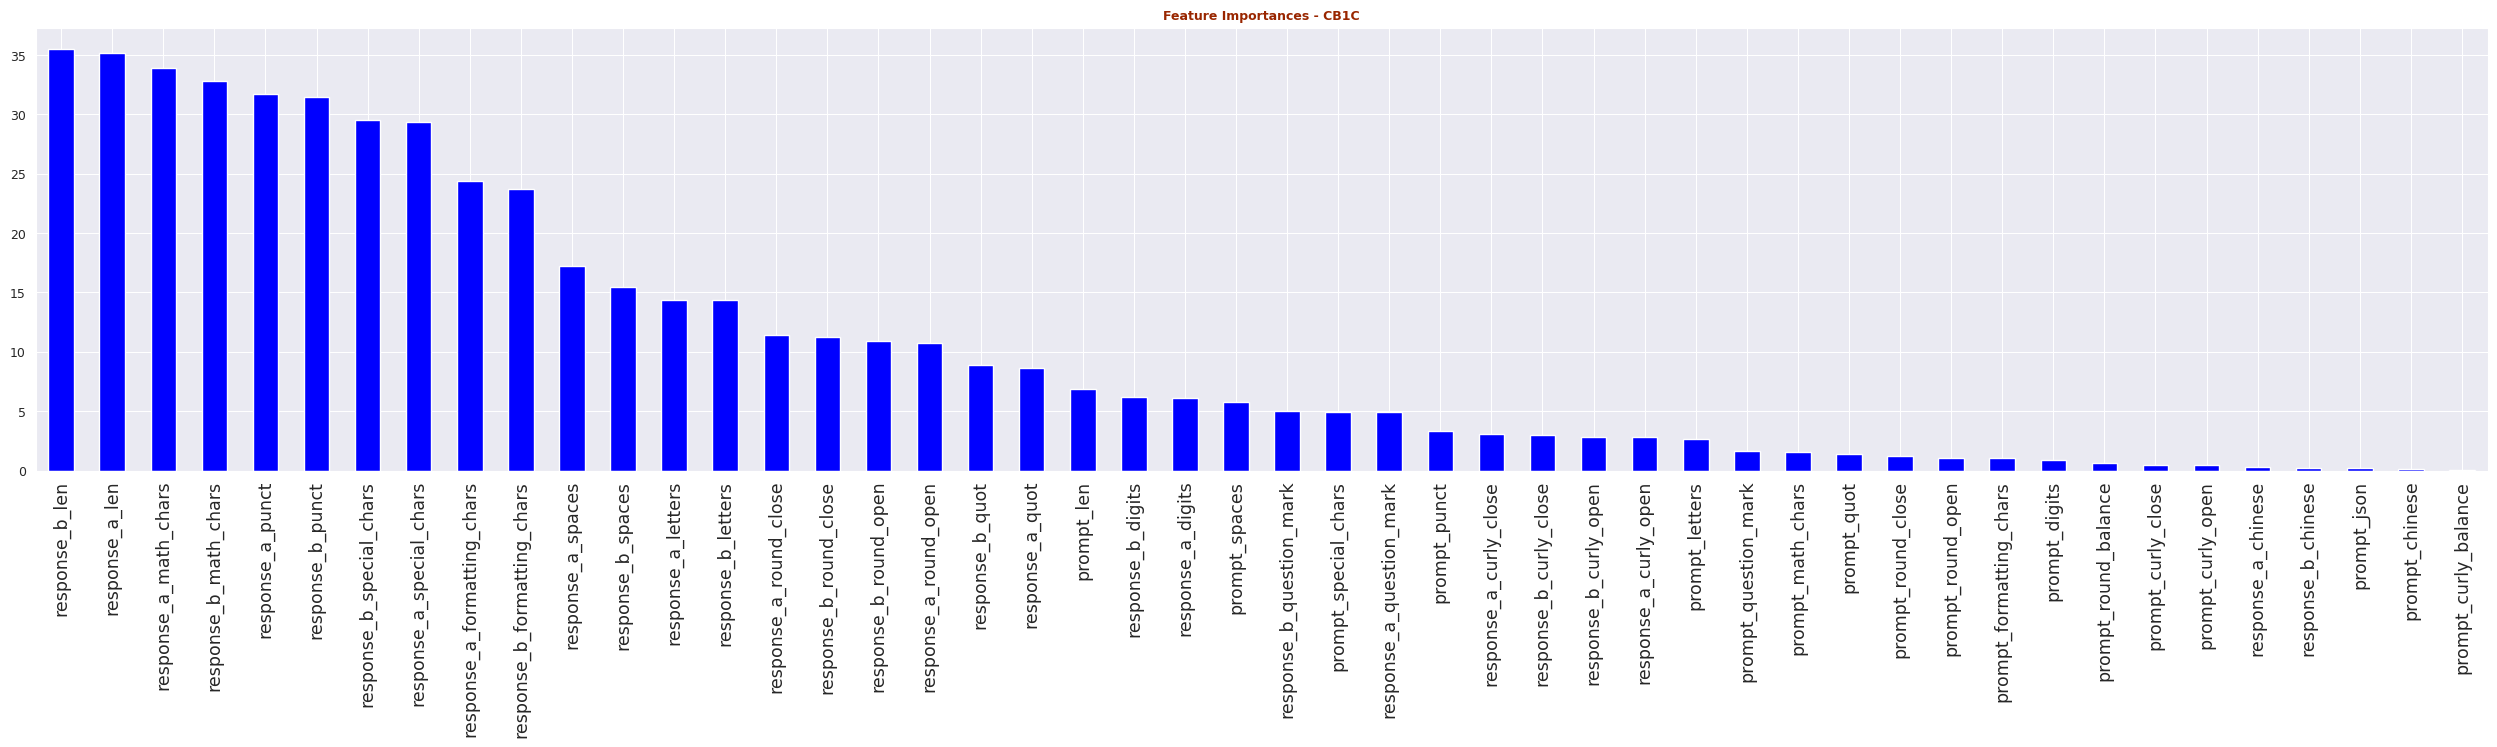



---> 0.598392 +- 0.001836 | OOF
---> 0.640520 +- 0.004664 | Train
---> Max best iteration = 583


==================== CB2C MODEL TRAINING ====================

Selected columns = 53


0it [00:00, ?it/s]


---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
CB2C Fold0           OOF = 0.596976 | Train = 0.631777 | Iter = 225 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
CB2C Fold1           OOF = 0.598937 | Train = 0.634074 | Iter = 256 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
CB2C Fold2           OOF = 0.600382 | Train = 0.626023 | Iter = 181 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
CB2C Fold3           OOF = 0.598916 | Train = 0.630982 | Iter = 212 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
CB2C Fold4           OOF = 0.599226 | Train = 0.637304 | Iter = 291 




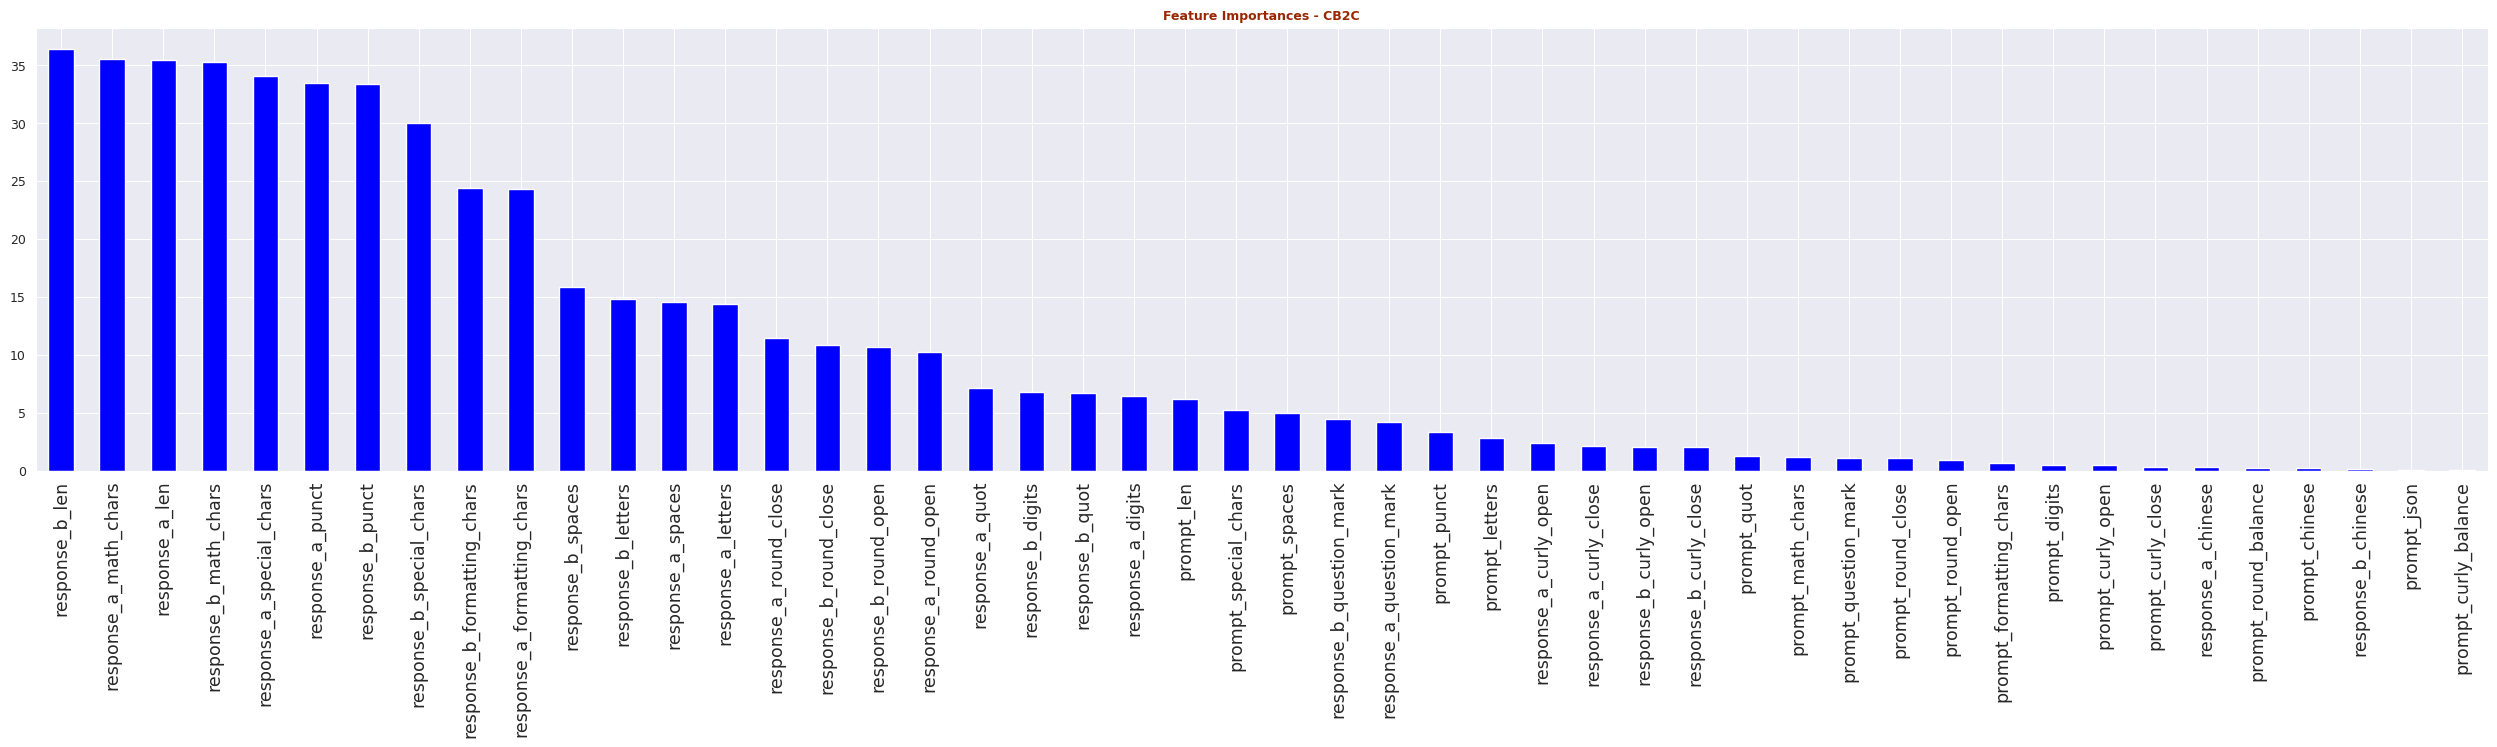



---> 0.598887 +- 0.001096 | OOF
---> 0.632032 +- 0.003722 | Train
---> Max best iteration = 291


==================== LGBM1C MODEL TRAINING ====================

Selected columns = 53


0it [00:00, ?it/s]


---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
LGBM1C Fold0         OOF = 0.597130 | Train = 0.648332 | Iter = 435 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
LGBM1C Fold1         OOF = 0.602756 | Train = 0.651015 | Iter = 443 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
LGBM1C Fold2         OOF = 0.602188 | Train = 0.652422 | Iter = 469 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
LGBM1C Fold3         OOF = 0.600361 | Train = 0.639330 | Iter = 320 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
LGBM1C Fold4         OOF = 0.602013 | Train = 0.636272 | Iter = 279 




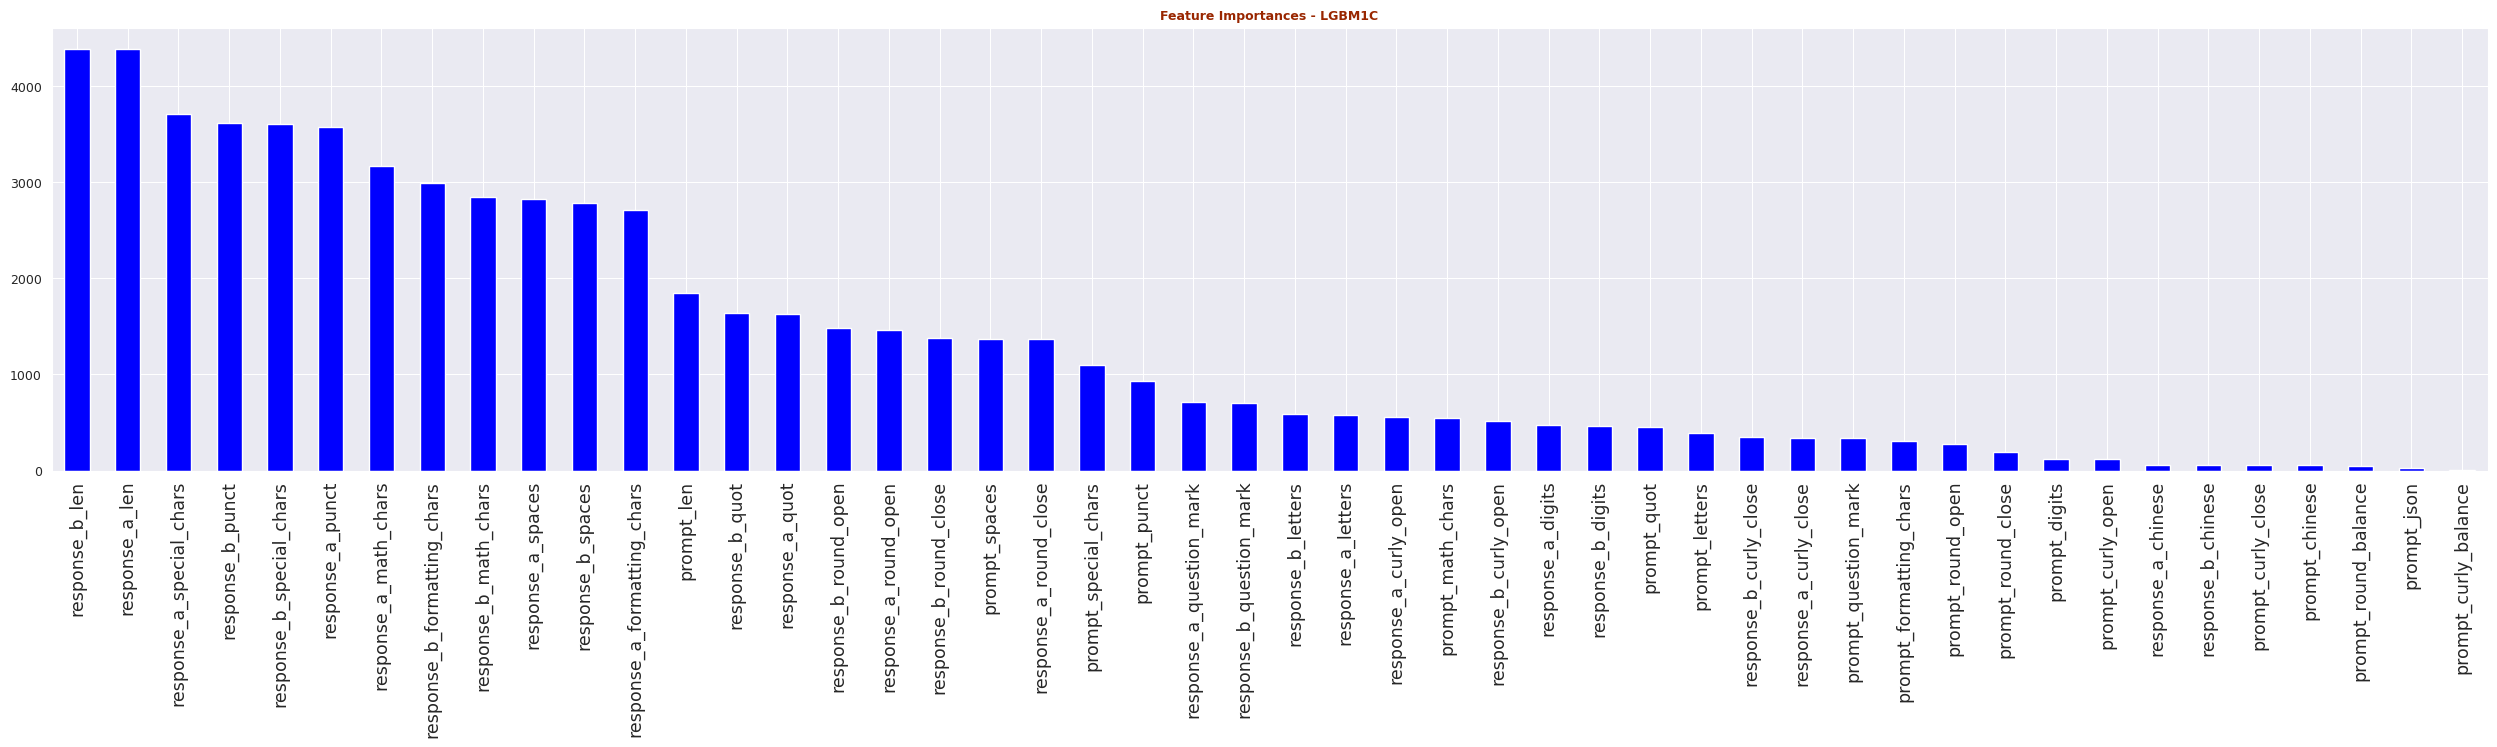



---> 0.600890 +- 0.002042 | OOF
---> 0.645474 +- 0.006474 | Train
---> Max best iteration = 469


==================== LGBM2C MODEL TRAINING ====================

Selected columns = 53


0it [00:00, ?it/s]


---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
LGBM2C Fold0         OOF = 0.593415 | Train = 0.625635 | Iter = 273 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
LGBM2C Fold1         OOF = 0.599143 | Train = 0.627106 | Iter = 286 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
LGBM2C Fold2         OOF = 0.596769 | Train = 0.618100 | Iter = 165 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
LGBM2C Fold3         OOF = 0.595097 | Train = 0.617576 | Iter = 167 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
LGBM2C Fold4         OOF = 0.597058 | Train = 0.618828 | Iter = 177 




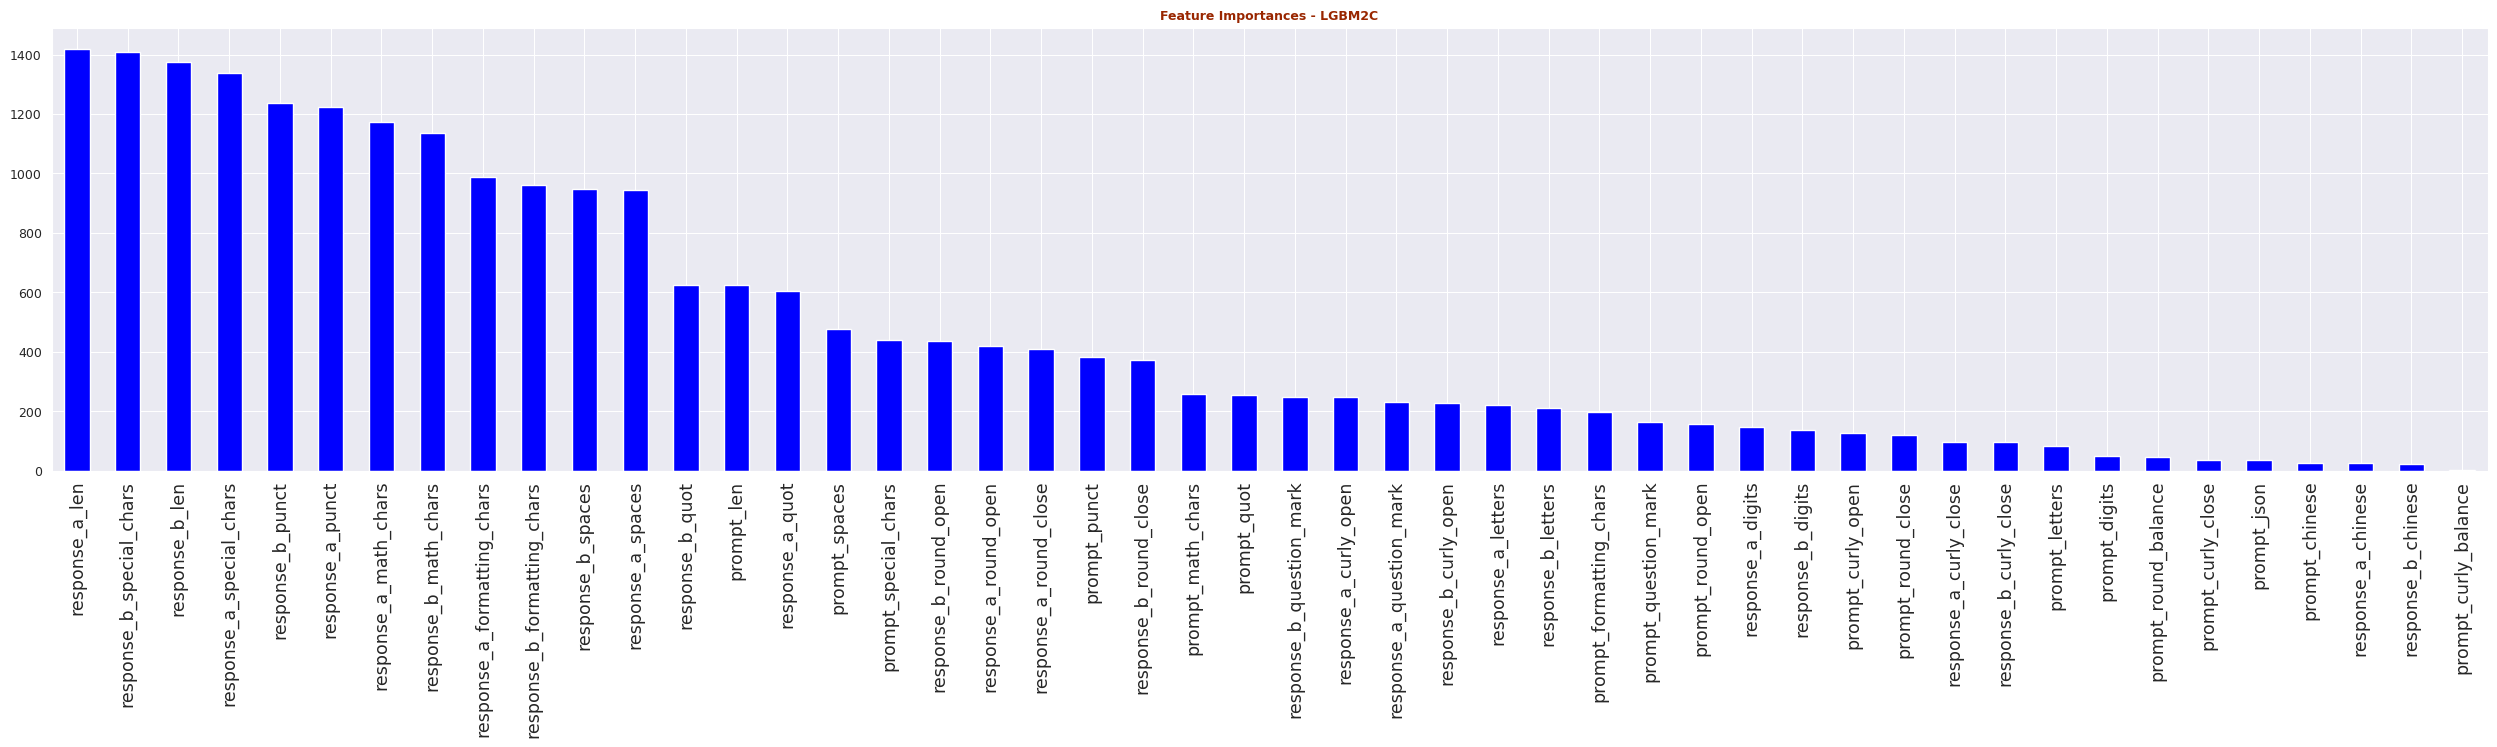



---> 0.596296 +- 0.001931 | OOF
---> 0.621449 +- 0.004065 | Train
---> Max best iteration = 286


==================== XGB1C MODEL TRAINING ====================

Selected columns = 53


0it [00:00, ?it/s]


---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
XGB1C Fold0          OOF = 0.594911 | Train = 0.660099 | Iter = 193 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
XGB1C Fold1          OOF = 0.598988 | Train = 0.647003 | Iter = 135 

---> Shapes = (77502, 48) (77502,) -- (19376, 48) (19376,) -- (3, 48)
XGB1C Fold2          OOF = 0.598472 | Train = 0.651519 | Iter = 147 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
XGB1C Fold3          OOF = 0.594116 | Train = 0.654181 | Iter = 158 

---> Shapes = (77503, 48) (77503,) -- (19375, 48) (19375,) -- (3, 48)
XGB1C Fold4          OOF = 0.597058 | Train = 0.656194 | Iter = 171 




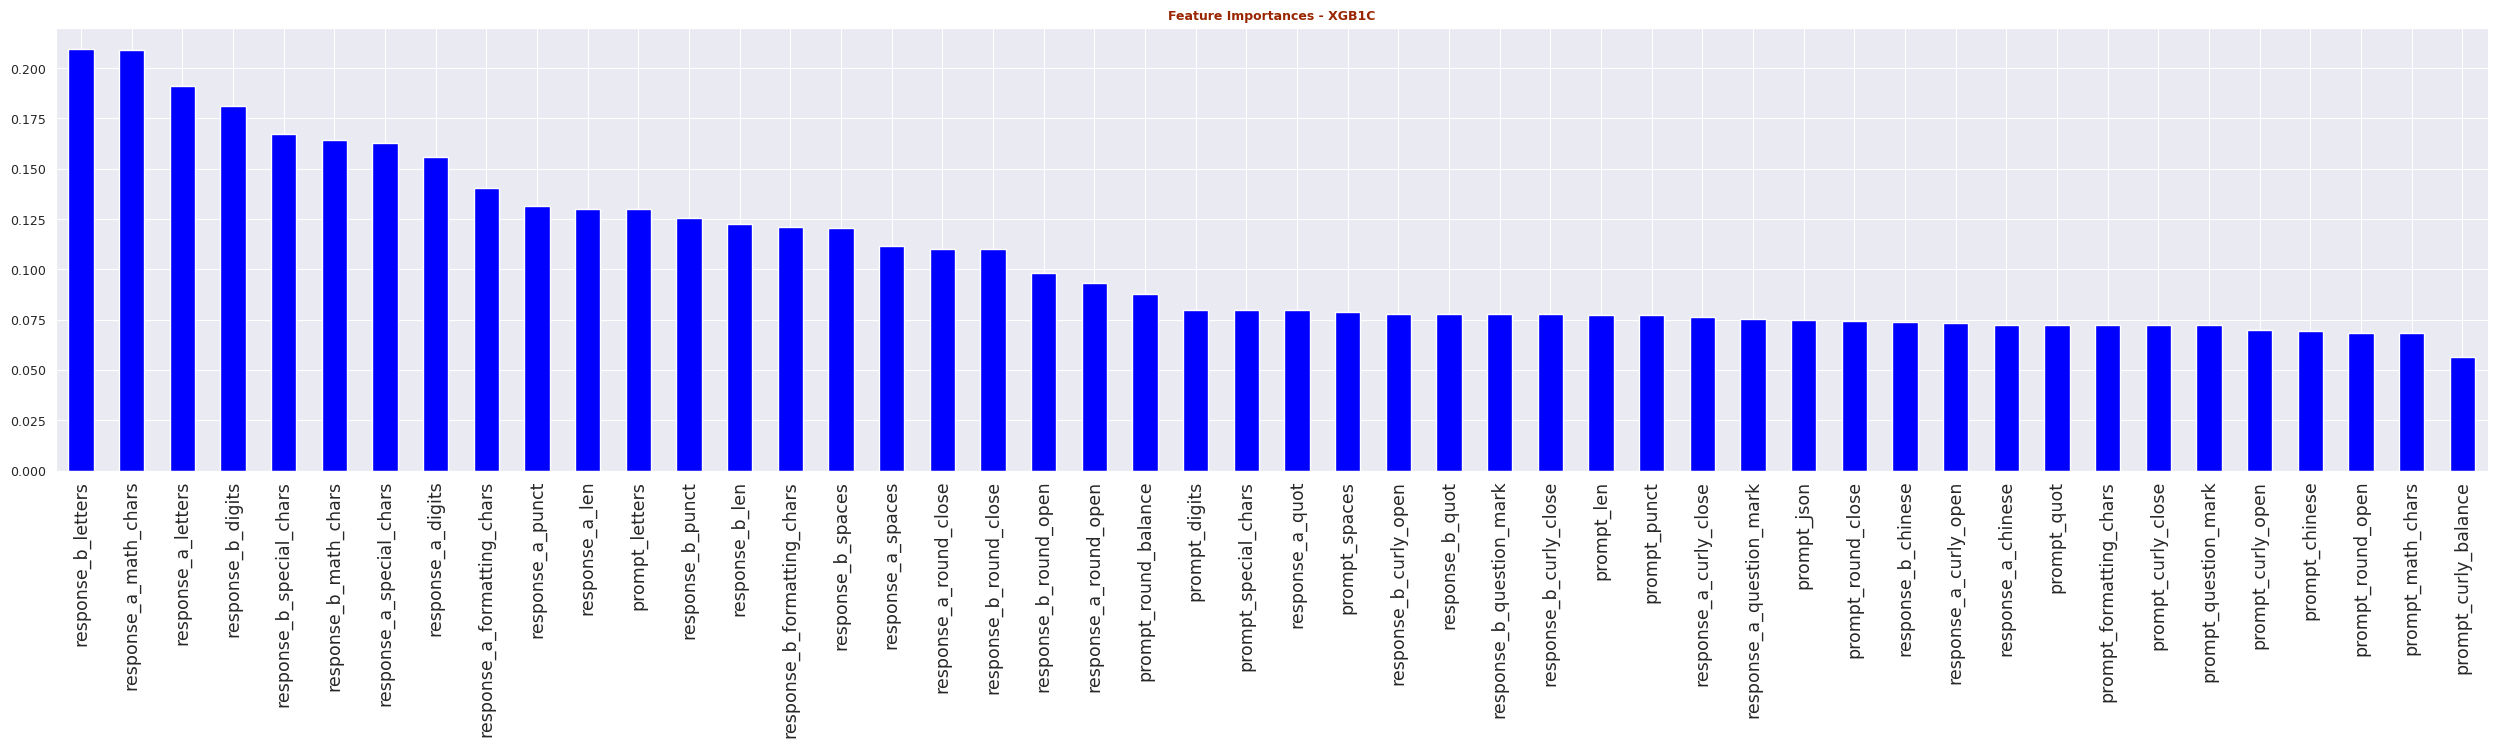



---> 0.596709 +- 0.001917 | OOF
---> 0.653799 +- 0.004404 | Train
---> Max best iteration = 193

CPU times: user 9min 15s, sys: 1min 20s, total: 10min 36s
Wall time: 4min 44s


In [7]:
%%time

# Model training:-
drop_cols = ["Source", "id", "Id", "Label", CFG.target, "fold_nb",
             'prompt', 'response_a', 'response_b', 'winner', 'model_a',
             'model_b', 'language', 'scored',
            ]

for method, mymodel in tqdm(Mdl_Master.items()):

    PrintColor(f"\n{'=' * 20} {method.upper()} MODEL TRAINING {'=' * 20}\n")

    md = \
    ModelTrainer(
        problem_type   = "binary",
        es             = CFG.nbrnd_erly_stp,
        target         = CFG.target,
        orig_req       = False,
        orig_all_folds = False,
        metric_lbl     = "accuracy",
        drop_cols      = drop_cols,
        )

    sel_mdl_cols = list(Xtest.columns)
    
    PrintColor(f"Selected columns = {len(sel_mdl_cols) :,.0f}", color = Fore.RED)
    
    fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter =  \
    md.MakeOfflineModel(
        Xtrain[sel_mdl_cols].copy(),
        deepcopy(ytrain),
        ygrp,
        Xtest[sel_mdl_cols].copy(),
        clone(mymodel),
        method,
        test_preds_req   = True,
        ftreimp_plot_req = CFG.ftre_imp_req,
        ntop = 50,
    )

    OOF_Preds[method]    = oof_preds
    Mdl_Preds[method]    = test_preds
    FittedModels[method] = fitted_models
    FtreImp[method]      = ftreimp

    del fitted_models, oof_preds, test_preds, ftreimp, sel_mdl_cols
    print()
    collect();

_ = utils.CleanMemory();


## **ENSEMBLE**

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]


---> Shapes = (77502, 5) (77502,) -- (19376, 5) (19376,) -- (3, 5)
LR1C Fold0           OOF = 0.596924 | Train = 0.600965 | Iter = -1 

---> Shapes = (77502, 5) (77502,) -- (19376, 5) (19376,) -- (3, 5)
LR1C Fold1           OOF = 0.602962 | Train = 0.599443 | Iter = -1 

---> Shapes = (77502, 5) (77502,) -- (19376, 5) (19376,) -- (3, 5)
LR1C Fold2           OOF = 0.601053 | Train = 0.600191 | Iter = -1 

---> Shapes = (77503, 5) (77503,) -- (19375, 5) (19375,) -- (3, 5)
LR1C Fold3           OOF = 0.599432 | Train = 0.600157 | Iter = -1 

---> Shapes = (77503, 5) (77503,) -- (19375, 5) (19375,) -- (3, 5)
LR1C Fold4           OOF = 0.600774 | Train = 0.600041 | Iter = -1 

---> 0.600229 +- 0.002000 | OOF
---> 0.600159 +- 0.000485 | Train
---> Max best iteration = 65,535


  0%|          | 0/5 [00:00<?, ?it/s]

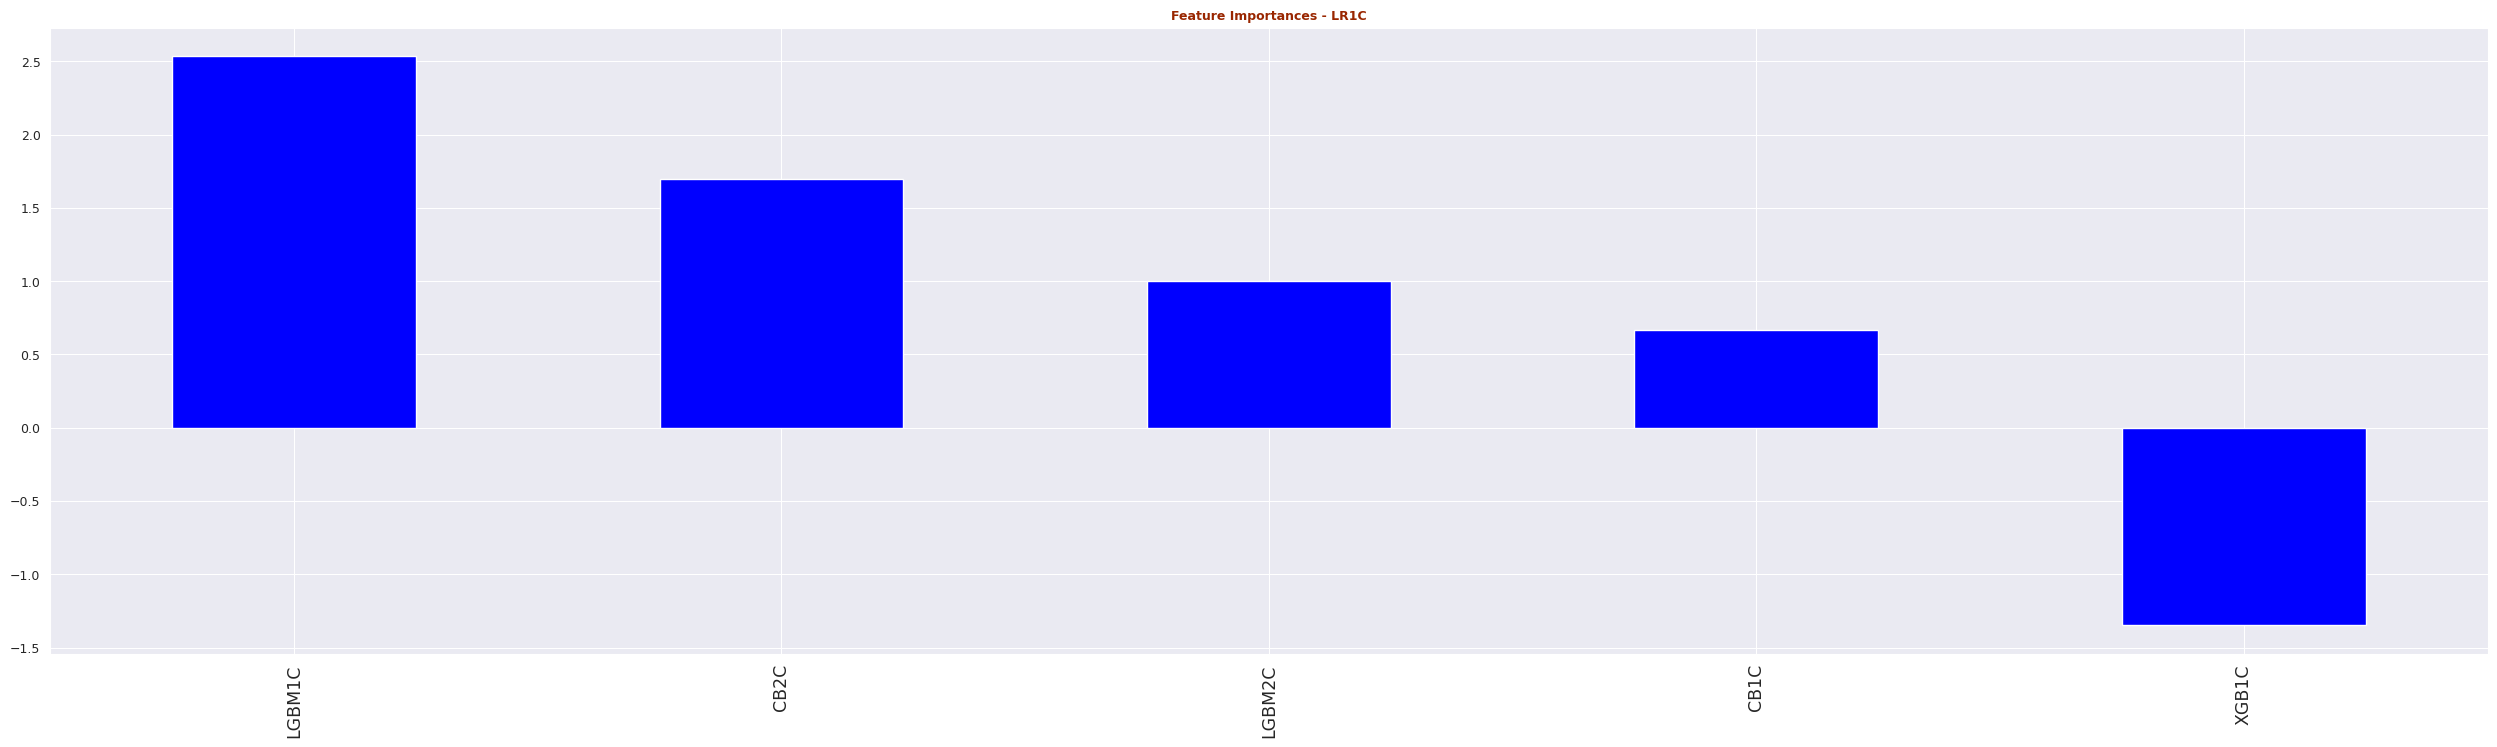


CPU times: user 2.27 s, sys: 1.68 s, total: 3.95 s
Wall time: 1.22 s


In [8]:
%%time 

Ens_Master = {f"LR1C" : LRC(C = 2.5, random_state = CFG.state, max_iter = 5000)}

oof_preds = pd.DataFrame(OOF_Preds).assign(**{"Source" : "Competition"})
mdl_preds = pd.DataFrame(Mdl_Preds).assign(**{"Source" : "Competition"})

for method, mymodel in tqdm(Ens_Master.items()):
    md = \
    ModelTrainer(
        problem_type   = "binary",
        es             = CFG.nbrnd_erly_stp,
        target         = CFG.target,
        orig_req       = False,
        orig_all_folds = False,
        metric_lbl     = "accuracy",
        drop_cols      = drop_cols,
        )

    sel_mdl_cols = list(mdl_preds.columns)

    fitted_models, oof_ens_preds, test_preds, ftreimp, mdl_best_iter  =  \
    md.MakeOfflineModel(
        oof_preds[sel_mdl_cols],
        ytrain,
        ygrp,
        mdl_preds[sel_mdl_cols],
        mymodel,
        method,
        test_preds_req   = True,
        ftreimp_plot_req = False,
        ntop = 50,
    )

    coefs_ = []
    for model in tqdm(fitted_models) :
        coefs_.append(model.coef_.flatten())

    coefs_ = \
    pd.DataFrame(np.stack(coefs_, axis=1),
                 index = list(set(sel_mdl_cols).difference(drop_cols))
                )
    
    print("\n\n")
    coefs_ = coefs_.mean(axis=1)
    md.PlotFtreImp(
        coefs_, method = method, ntop = 50, title_specs = CFG.title_specs
    )
    

# **THRESHOLD ADJUSTMENT**

We will try and find an optimal cutoff using a very basic search to elicit perhaps better results from the past version. This can be done using [TunedThresholdClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TunedThresholdClassifierCV.html) for sklearn 1.5.0 and later. One can use scipy.minimize and Optuna too for this step. <br>

In [9]:
%%time 

best_score = \
pd.DataFrame(
    columns = ["BestCutoff", "BestScore"], 
    index = range(CFG.n_splits)
)

for fold_nb, (_, dev_idx) in enumerate(cv.split(oof_preds, ytrain)):
    ypreds = oof_ens_preds[dev_idx]
    ytrue  = ytrain.values[dev_idx]

    tuned_scores = {}
    
    for i in np.arange(0.40, 0.70, 0.0005):
        score = utils.ScoreMetric(ytrue, np.where(ypreds > i, 1, 0))
        tuned_scores[i] = score

    best_cutoff = max(tuned_scores, key= tuned_scores.get)
    max_score   = tuned_scores[best_cutoff]

    best_score.loc[fold_nb] = [best_cutoff, max_score]
    
    PrintColor(
        f"Fold{fold_nb} - Best cutoff = {best_cutoff :.4f} score = {max_score :.6f}",
        color = Fore.CYAN
    )

best_score = best_score.mean(axis=0).values
cutoff, score = best_score[0], best_score[1]
PrintColor(
    f"\nOverall - Best cutoff = {cutoff :.4f} score = {score :.6f}",
    color = Fore.BLUE
)

Fold0 - Best cutoff = 0.4905 score = 0.598988
Fold1 - Best cutoff = 0.4905 score = 0.604769
Fold2 - Best cutoff = 0.4930 score = 0.603169
Fold3 - Best cutoff = 0.4940 score = 0.600826
Fold4 - Best cutoff = 0.5065 score = 0.603768

Overall - Best cutoff = 0.4949 score = 0.602304
CPU times: user 6.2 s, sys: 6.94 ms, total: 6.21 s
Wall time: 6.2 s


# **SUBMISSION**

In [10]:
%%time 

sub_fl[CFG.target] = np.where(test_preds > cutoff, "model_b", "model_a")
sub_fl.to_csv("submission.csv", index = None)


joblib.dump(FittedModels,  "FittedModels.joblib")
joblib.dump(fitted_models, "EnsembleModel.joblib")
pd.DataFrame(FtreImp).to_csv(f"FtreImp.csv")
pd.DataFrame(OOF_Preds).to_csv("OOF_Preds.csv")

!ls

!head submission.csv

EnsembleModel.joblib  FtreImp.csv    __notebook__.ipynb  submission.csv
FittedModels.joblib   OOF_Preds.csv  catboost_info	 xgb_optimize.log
id,winner
327228,model_b
1139415,model_b
1235630,model_a
CPU times: user 1.7 s, sys: 125 ms, total: 1.82 s
Wall time: 3.99 s
